# Neutrino event classification

This mini-project's dataset is comprised of a number of small files containing images of simulated neutrino interactions in a hypothetical detector that looks an awful lot like the detectors of the NOvA experiment. For each neutrino interaction the images consist of two $100 \times 80$ pixel images that represent the $x \times z$ and $y \times z$ projections of the tracks of particles in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| neutrino1.h5 | The 1st HDF5 file containing event images and meta deta |
| $\vdots$ | The middle ones |
| neutrino200.h5| The 200th HDF5 file|


The images show the energy deposited by simulated neutrinos in a NOvA like detector. Some of the meta information in the hdf5 file is described below

| Label | Description |
| ----------- | ----------- |
| neutrino/nuenergy | Neutrino Energy (GeV) |
| neutrino/lepenergy | Lepton Energy (GeV) |
| neutrino/finalstate | Interaction |
| neutrino/finalstate | Final State |
 

The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

The $interaction$ says what kind of interaction occured and is defined in the enumeration below.

## Machine learning tasks
1. Develop a machine learning classifier that can successfully identify $\nu_\mu$ charged-current events
2. Test your machine learning classifier and investigate how the efficiency of the classifier depends on the meta data variables shown above

### Potential extensions
1. Write a machine learning algorithm to determine the energy of the neutrino
2. Write a machine learning algorithm to determine the flavour of the neutrino
3. Write a machine learning algorithm to determine $y=$ lepton energy over neutrino energy
4. Write a machine learning algorithm to determine the number of protons or pions
5. Write a machine learning algorithm to determine the interaction mode.




In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 

import math

from IPython.display import clear_output

In [3]:
import enum 
class Interaction(enum.Enum):
    kNumuQE =0           # Numu CC QE interaction
    kNumuRes =1           # Numu CC Resonant interaction
    kNumuDIS = 2          # Numu CC DIS interaction
    kNumuOther = 3        # Numu CC, other than above
    kNueQE = 4            # Nue CC QE interaction
    kNueRes = 5           # Nue CC Resonant interaction
    kNueDIS = 6           # Nue CC DIS interaction
    kNueOther = 7         # Nue CC, other than above
    kNutauQE = 8          # Nutau CC QE interaction
    kNutauRes = 9         # Nutau CC Resonant interaction
    kNutauDIS =10         # Nutau CC DIS interaction
    kNutauOther =11       # Nutau CC, other than above
    kNuElectronElastic = 12# NC Nu On E Scattering
    kNC =13                # NC interaction
    kCosmic =14           # Cosmic ray background
    kOther =15            # Something else.  Tau?  Hopefully we don't use this
    kNIntType=16          # Number of interaction types, used like a vector size

    
class FinalState(enum.Enum):
    kNumu0tr0sh=0          # Numu CC - no track no shower
    kNumu0tr1sh=1          # Numu CC - no track  1 shower
    kNumu0tr2sh=enum.auto()          # Numu CC - no track  2 shower
    kNumu0trMsh=enum.auto()          # Numu CC - no track 3+ shower
    kNumu1tr0sh=enum.auto()          # Numu CC -  1 track no shower
    kNumu1tr1sh=enum.auto()          # Numu CC -  1 track  1 shower
    kNumu1tr2sh=enum.auto()          # Numu CC -  1 track  2 shower
    kNumu1trMsh=enum.auto()          # Numu CC -  1 track 3+ shower
    kNumu2tr0sh=enum.auto()          # Numu CC -  2 track no shower
    kNumu2tr1sh=enum.auto()          # Numu CC -  2 track  1 shower
    kNumu2tr2sh=enum.auto()          # Numu CC -  2 track  2 shower
    kNumu2trMsh=enum.auto()          # Numu CC -  2 track 3+ shower
    kNumuMtr0sh=enum.auto()          # Numu CC - 3+ track no showe
    kNumuMtr1sh=enum.auto()          # Numu CC - 3+ track  1 shower
    kNumuMtr2sh=enum.auto()          # Numu CC - 3+ track  2 showe
    kNumuMtrMsh=enum.auto()          # Numu CC - 3+ track 3+ shower
    kNue0tr0sh=enum.auto()           # Nue CC - no track no shower
    kNue0tr1sh=enum.auto()           # Nue CC - no track  1 shower
    kNue0tr2sh=enum.auto()           # Nue CC - no track  2 showe
    kNue0trMsh=enum.auto()           # Nue CC - no track 3+ shower
    kNue1tr0sh=enum.auto()           # Nue CC -  1 track no shower
    kNue1tr1sh=enum.auto()           # Nue CC -  1 track  1 shower
    kNue1tr2sh=enum.auto()           # Nue CC -  1 track  2 shower
    kNue1trMsh=enum.auto()           # Nue CC -  1 track 3+ shower
    kNue2tr0sh=enum.auto()           # Nue CC -  2 track no shower
    kNue2tr1sh=enum.auto()           # Nue CC -  2 track  1 shower
    kNue2tr2sh=enum.auto()           # Nue CC -  2 track  2 shower
    kNue2trMsh=enum.auto()           # Nue CC -  2 track 3+ shower
    kNueMtr0sh=enum.auto()           # Nue CC - 3+ track no shower
    kNueMtr1sh=enum.auto()           # Nue CC - 3+ track  1 shower
    kNueMtr2sh=enum.auto()           # Nue CC - 3+ track  2 shower
    kNueMtrMsh=enum.auto()           # Nue CC - 3+ track 3+ shower
    kNC0tr0sh=enum.auto()           # NC CC - no track no shower
    kNC0tr1sh=enum.auto()           # NC CC - no track  1 shower
    kNC0tr2sh=enum.auto()           # NC CC - no track  2 shower
    kNC0trMsh=enum.auto()           # NC CC - no track 3+ shower
    kNC1tr0sh=enum.auto()           # NC CC -  1 track no shower
    kNC1tr1sh=enum.auto()           # NC CC -  1 track  1 shower
    kNC1tr2sh=enum.auto()           # NC CC -  1 track  2 shower
    kNC1trMsh=enum.auto()           # NC CC -  1 track 3+ shower
    kNC2tr0sh=enum.auto()           # NC CC -  2 track no shower
    kNC2tr1sh=enum.auto()           # NC CC -  2 track  1 shower
    kNC2tr2sh=enum.auto()           # NC CC -  2 track  2 shower
    kNC2trMsh=enum.auto()           # NC CC -  2 track 3+ shower
    kNCMtr0sh=enum.auto()           # NC CC - 3+ track no shower
    kNCMtr1sh=enum.auto()           # NC CC - 3+ track  1 shower
    kNCMtr2sh=enum.auto()           # NC CC - 3+ track  2 shower
    kNCMtrMsh=enum.auto()           # NC CC - 3+ track 3+ shower
    kCosmicFS=enum.auto()           # Cosmic ray background
    kOtherFS=enum.auto()            # Something else.  Tau?  Hopefully we don't use this
    kNFStType=enum.auto()            # Number of interaction types, used like a vector size



In [4]:
# import the urllib library
import urllib.request
 
# Copy a network object to a local file
urllib.request.urlretrieve('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/nova/neutrino1.h5', "neutrino1.h5")

#Open the local h5 file with h5py
df=h5py.File('neutrino1.h5','r')

In [39]:
#Print the keys in the neutrino meta data
#print(df.keys())
#print(df['neutrino'].keys())

#Get an numpy array containing the event image, and reshape it from flat to 2x100x80
images = []

print(np.shape(df['cvnmap']))
n = 0
for i in range(0,math.floor(len(df['cvnmap']))):
  event0=np.array(df['cvnmap'][i]).reshape((2,100,80))
  #print(df['cvnmap'][i].shape)
  #print(event0.shape)
  #print(event0[1].shape)
  #print(event0[1].T.shape)

  

  n+=1
  clear_output()
  print(str(100*round(n/math.floor(len(df['cvnmap'])),2)) + "%")
  images.append(event0[1].T)

images = np.array(images)
print(images.shape)

  
  

2.0%


KeyboardInterrupt: ignored

<KeysViewHDF5 ['cvnmap', 'neutrino']>
<KeysViewHDF5 ['cycle', 'evt', 'finalstate', 'finalstateprong', 'interaction', 'lepenergy', 'nuenergy', 'parent', 'particles', 'rec.training.trainingdata_idx', 'run', 'subevt', 'subrun', 'vtxx', 'vtxy', 'vtxz']>
x: 0     y: 27       20
x: 0     y: 28       4
x: 0     y: 29       3
x: 0     y: 30       4
x: 0     y: 31       6
x: 0     y: 32       3
x: 0     y: 33       5
x: 0     y: 34       4
x: 0     y: 35       5
x: 0     y: 36       6
x: 0     y: 37       4
x: 0     y: 38       4
x: 0     y: 39       5
x: 0     y: 40       6
x: 0     y: 41       6
x: 0     y: 42       12
x: 0     y: 43       19
x: 0     y: 44       4
x: 1     y: 22       8
x: 1     y: 23       11
x: 1     y: 24       5
x: 1     y: 28       10
x: 1     y: 43       41
x: 1     y: 46       21
x: 1     y: 47       5
x: 2     y: 19       5
x: 2     y: 30       20
x: 2     y: 33       6
x: 2     y: 34       21
x: 2     y: 35       7
x: 2     y: 42       17
x: 2     y: 43       14
x: 

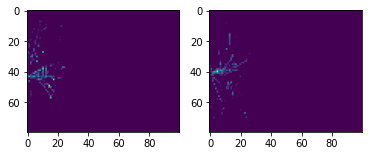

In [19]:
print(df.keys())
print(df["neutrino"].keys())

event0=np.array(df['cvnmap'][3]).reshape((2,100,80))

#Plot the first event, look it is a nice long muon track
fig, ax = plt.subplots(1,2)
ax[0].imshow(event0[1].T)
ax[1].imshow(event0[0].T)

for x in range(len(event0[1])):
  for y in range(len(event0[1][0])):
    if event0[1][x][y] != 0: print("x:", x, "    y:", y, "     ", event0[1][x][y])

In [ ]:
print("Neutrino Final State code",df['neutrino']['finalstate'][3])
print("Interaction was ",Interaction(df['neutrino']['interaction'][3]))
print("Neutrino energy",df['neutrino']['nuenergy'][3],"GeV")

Neutrino Final State code [46]
Interaction was  Interaction.kNC
Neutrino energy [13.677229] GeV


(array([3358., 1891., 1013.,  394.,  184.,   85.,   44.,   14.,    8.,
          10.]),
 array([ 0.      ,  8.229538, 16.459076, 24.688614, 32.91815 , 41.14769 ,
        49.377228, 57.606766, 65.8363  , 74.06584 , 82.29538 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

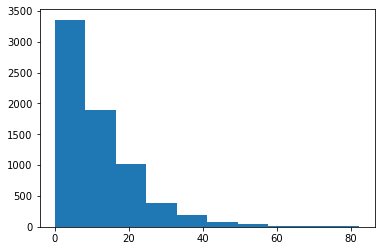

In [ ]:
fs=np.array(df['neutrino']['finalstate'])
nuenergy=np.array(df['neutrino']['nuenergy'])
fig, ax = plt.subplots()
ax.hist(nuenergy)